In [ ]:
# Importing necessary packages, and classes adapted from decision boundary visualization studies

from huggingface_hub import hf_hub_download, HfApi
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
import shutil

import project_code.model.Models as Models
import Attacks
import Tools
from ssnp import SSNP, visualize_decision_boundaries

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Importing MNIST dataset from online
data_dir = os.path.abspath(os.path.join(os.getcwd(), "../data"))
MNIST_data = datasets.MNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())

# pre-select adversarial examples
ADVERSARIAL_BATCH_N = 200
SEED = 42  # For reproducibility

torch.manual_seed(SEED)
random_indices = torch.randint(0, MNIST_data.data.shape[0], (ADVERSARIAL_BATCH_N,))

adversarial_images = MNIST_data.data[random_indices].float()
adversarial_labels = MNIST_data.targets[random_indices]

In [3]:
# Importing the MNIST classifier model
MODEL_SETTING = "medium"

if MODEL_SETTING == "small":
    # Use SmallConvNet for MNIST classification
    MNIST_model = Models.SmallConvNet()
elif MODEL_SETTING == "medium":
    # Use ConvNet for MNIST classification
    MNIST_model = Models.MediumConvNet()

device_torch = torch.device(
    "mps" if torch.backends.mps.is_available() else 
    "cuda" if torch.cuda.is_available() else 
    "cpu"
    )

In [4]:
# Import the SSNP pre-trained model weights from HuggingFace
IMPORT_MODEL = False
SSNP_REPO_ID = "cmlavo/SSNP"
SSNP_MODEL_FILENAME = "ssnp_MNIST.keras"
local_path = os.path.abspath(os.path.join(os.getcwd(), "../models/ssnp", SSNP_MODEL_FILENAME))

if IMPORT_MODEL:    
    cached_path = hf_hub_download(repo_id=SSNP_REPO_ID, filename=SSNP_MODEL_FILENAME)    
    shutil.copy(cached_path, local_path)
    print(f"Model saved to {local_path}")


 56/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Processing 10200 points for 2D projection...
pts: [[-5.78625154 -6.5584507 ]
 [-5.78625154 -6.51662316]
 [-5.78625154 -6.47479563]
 ...
 [ 5.04568672  5.86432724]
 [ 5.04568672  5.90615478]
 [ 5.04568672  5.94798231]]
x, y intervals: [-5.78625154 -5.75002433 -5.71379711 -5.67756989 -5.64134267 -5.60511545
 -5.56888824 -5.53266102 -5.4964338  -5.46020658 -5.42397936 -5.38775214
 -5.35152493 -5.31529771 -5.27907049 -5.24284327 -5.20661605 -5.17038883
 -5.13416162 -5.0979344  -5.06170718 -5.02547996 -4.98925274 -4.95302552
 -4.91679831 -4.88057109 -4.84434387 -4.80811665 -4.77188943 -4.73566221
 -4.699435   -4.66320778 -4.62698056 -4.59075334 -4.55452612 -4.51829891
 -4.48207169 -4.44584447 -4.40961725 -4.37339003 -4.33716281 -4.3009356
 -4.26470838 -4.22848116 -4.19225394 -4.15602672 -4.1197995  -4.08357229
 -4.04734507 -4.01111785 -3.97489063 -3.93866341 -3.90243619 -3.86620898
 -3.82998176 -3.79375454 -3.75752732 -3.7213001  -3.68507288 -3.64884567

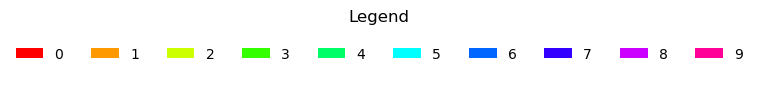

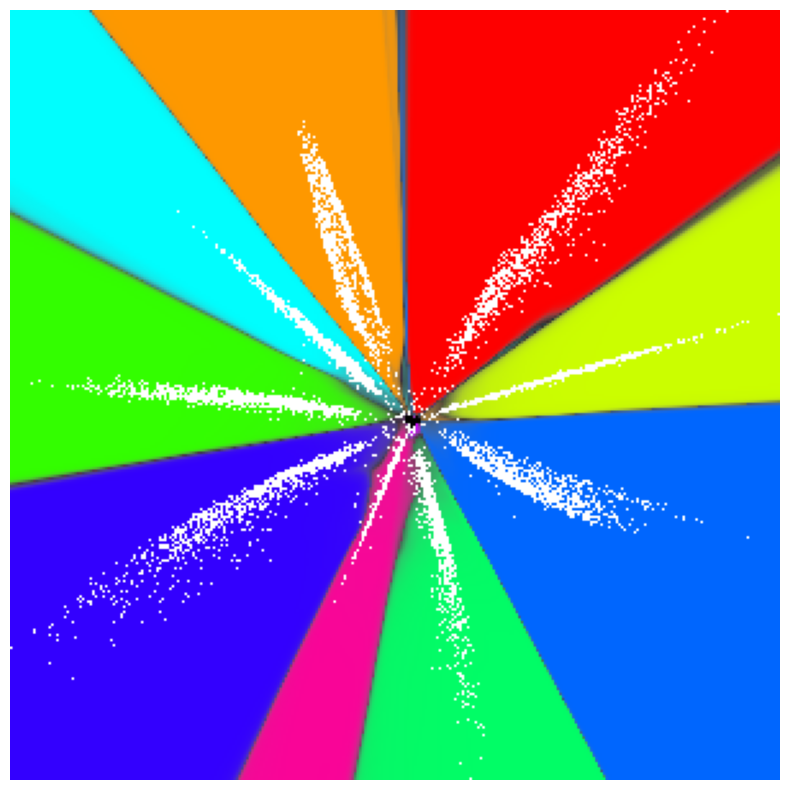

Error while downloading from https://cdn-lfs-us-1.hf.co/repos/07/49/0749ed84f1ba0552557ef5cdfff11da1bf256d175123daea6ae2b4a31cb452a3/6c046a2314a81f4f921b9fb2159e011d9c6defb0a349c5e3853e60f2852f6d31?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model_Cyclic.pth%3B+filename%3D%22model_Cyclic.pth%22%3B&Expires=1749580485&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0OTU4MDQ4NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzA3LzQ5LzA3NDllZDg0ZjFiYTA1NTI1NTdlZjVjZGZmZjExZGExYmYyNTZkMTc1MTIzZGFlYTZhZTJiNGEzMWNiNDUyYTMvNmMwNDZhMjMxNGE4MWY0ZjkyMWI5ZmIyMTU5ZTAxMWQ5YzZkZWZiMGEzNDljNWUzODUzZTYwZjI4NTJmNmQzMT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=XKtuPu9OKwnHElmLLKJSL2Am6cFODUZ5FmNhADlxM5hRkGRKSyNhkqZ%7Ey%7EtmtbqtBuStD-i1OCm8SaIvN7PeBSwoQ8FqCjbJIxggvdwwMrhHDOQGs%7EMdAjUlhZP9mfvWmuFAgK-lueaPiIeVT%7EGZt55RRrq6AhXR6g3MOvxtkV58rs%7ELYaz3T3ZZLb7%7E9byTHkPSKD0Kek1OsC0xmd3-L5z%7EDQm07gnBRirb3JrDcIjiJ3MbqwkYoGll

 84/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Processing 10200 points for 2D projection...
pts: [[-5.78625154 -6.5584507 ]
 [-5.78625154 -6.51662316]
 [-5.78625154 -6.47479563]
 ...
 [ 5.04568672  5.86432724]
 [ 5.04568672  5.90615478]
 [ 5.04568672  5.94798231]]
x, y intervals: [-5.78625154 -5.75002433 -5.71379711 -5.67756989 -5.64134267 -5.60511545
 -5.56888824 -5.53266102 -5.4964338  -5.46020658 -5.42397936 -5.38775214
 -5.35152493 -5.31529771 -5.27907049 -5.24284327 -5.20661605 -5.17038883
 -5.13416162 -5.0979344  -5.06170718 -5.02547996 -4.98925274 -4.95302552
 -4.91679831 -4.88057109 -4.84434387 -4.80811665 -4.77188943 -4.73566221
 -4.699435   -4.66320778 -4.62698056 -4.59075334 -4.55452612 -4.51829891
 -4.48207169 -4.44584447 -4.40961725 -4.37339003 -4.33716281 -4.3009356
 -4.26470838 -4.22848116 -4.19225394 -4.15602672 -4.1197995  -4.08357229
 -4.04734507 -4.01111785 -3.97489063 -3.93866341 -3.90243619 -3.86620898
 -3.82998176 -3.79375454 -3.75752732 -3.7213001  -3.68507288 -3.64884567

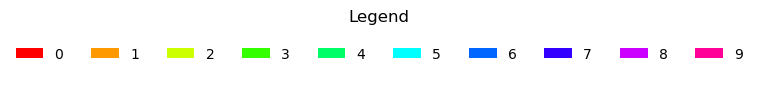

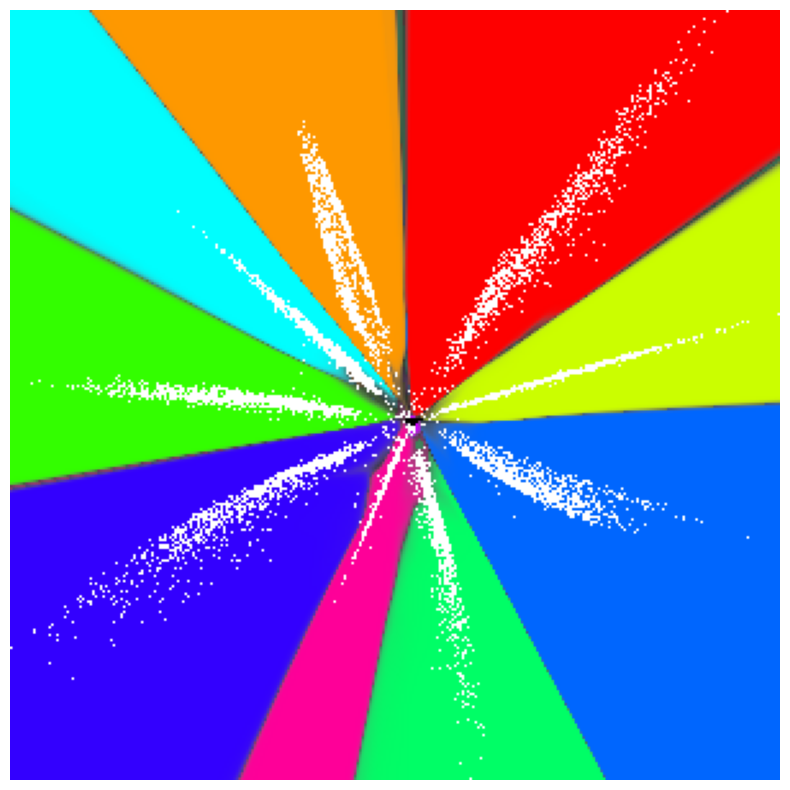

 87/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Processing 10200 points for 2D projection...
pts: [[-5.78625154 -6.5584507 ]
 [-5.78625154 -6.51662316]
 [-5.78625154 -6.47479563]
 ...
 [ 5.04568672  5.86432724]
 [ 5.04568672  5.90615478]
 [ 5.04568672  5.94798231]]
x, y intervals: [-5.78625154 -5.75002433 -5.71379711 -5.67756989 -5.64134267 -5.60511545
 -5.56888824 -5.53266102 -5.4964338  -5.46020658 -5.42397936 -5.38775214
 -5.35152493 -5.31529771 -5.27907049 -5.24284327 -5.20661605 -5.17038883
 -5.13416162 -5.0979344  -5.06170718 -5.02547996 -4.98925274 -4.95302552
 -4.91679831 -4.88057109 -4.84434387 -4.80811665 -4.77188943 -4.73566221
 -4.699435   -4.66320778 -4.62698056 -4.59075334 -4.55452612 -4.51829891
 -4.48207169 -4.44584447 -4.40961725 -4.37339003 -4.33716281 -4.3009356
 -4.26470838 -4.22848116 -4.19225394 -4.15602672 -4.1197995  -4.08357229
 -4.04734507 -4.01111785 -3.97489063 -3.93866341 -3.90243619 -3.86620898
 -3.82998176 -3.79375454 -3.75752732 -3.7213001  -3.68507288 -3.64884567

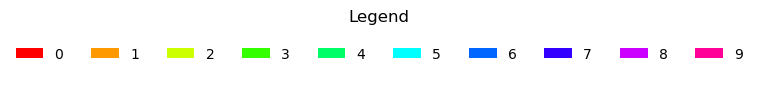

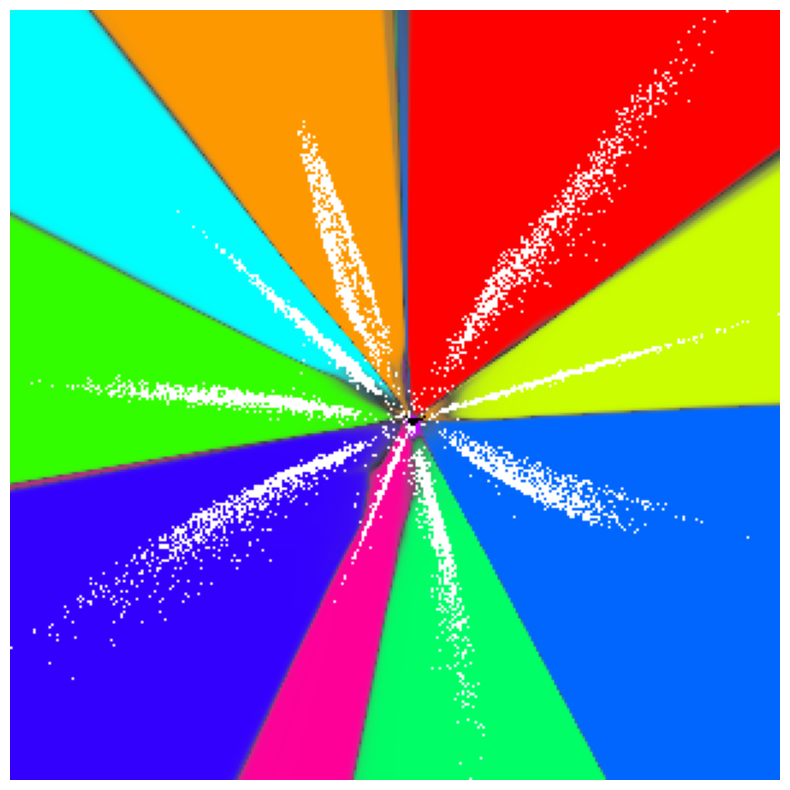

 89/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Processing 10200 points for 2D projection...
pts: [[-5.78625154 -6.5584507 ]
 [-5.78625154 -6.51662316]
 [-5.78625154 -6.47479563]
 ...
 [ 5.04568672  5.86432724]
 [ 5.04568672  5.90615478]
 [ 5.04568672  5.94798231]]
x, y intervals: [-5.78625154 -5.75002433 -5.71379711 -5.67756989 -5.64134267 -5.60511545
 -5.56888824 -5.53266102 -5.4964338  -5.46020658 -5.42397936 -5.38775214
 -5.35152493 -5.31529771 -5.27907049 -5.24284327 -5.20661605 -5.17038883
 -5.13416162 -5.0979344  -5.06170718 -5.02547996 -4.98925274 -4.95302552
 -4.91679831 -4.88057109 -4.84434387 -4.80811665 -4.77188943 -4.73566221
 -4.699435   -4.66320778 -4.62698056 -4.59075334 -4.55452612 -4.51829891
 -4.48207169 -4.44584447 -4.40961725 -4.37339003 -4.33716281 -4.3009356
 -4.26470838 -4.22848116 -4.19225394 -4.15602672 -4.1197995  -4.08357229
 -4.04734507 -4.01111785 -3.97489063 -3.93866341 -3.90243619 -3.86620898
 -3.82998176 -3.79375454 -3.75752732 -3.7213001  -3.68507288 -3.64884567

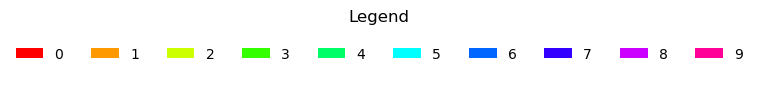

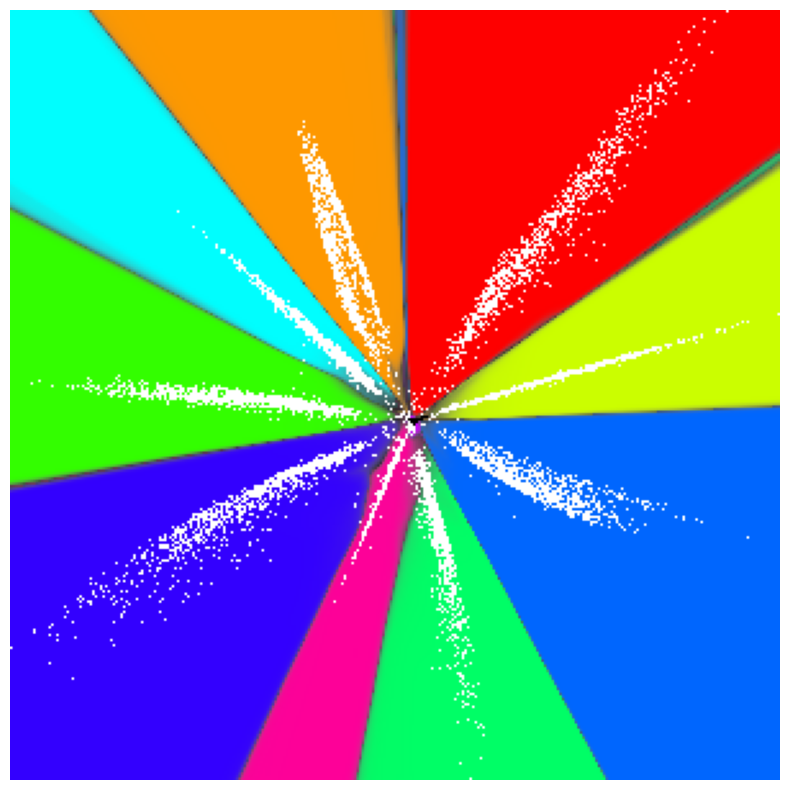

 84/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Processing 10200 points for 2D projection...
pts: [[-5.78625154 -6.5584507 ]
 [-5.78625154 -6.51662316]
 [-5.78625154 -6.47479563]
 ...
 [ 5.04568672  5.86432724]
 [ 5.04568672  5.90615478]
 [ 5.04568672  5.94798231]]
x, y intervals: [-5.78625154 -5.75002433 -5.71379711 -5.67756989 -5.64134267 -5.60511545
 -5.56888824 -5.53266102 -5.4964338  -5.46020658 -5.42397936 -5.38775214
 -5.35152493 -5.31529771 -5.27907049 -5.24284327 -5.20661605 -5.17038883
 -5.13416162 -5.0979344  -5.06170718 -5.02547996 -4.98925274 -4.95302552
 -4.91679831 -4.88057109 -4.84434387 -4.80811665 -4.77188943 -4.73566221
 -4.699435   -4.66320778 -4.62698056 -4.59075334 -4.55452612 -4.51829891
 -4.48207169 -4.44584447 -4.40961725 -4.37339003 -4.33716281 -4.3009356
 -4.26470838 -4.22848116 -4.19225394 -4.15602672 -4.1197995  -4.08357229
 -4.04734507 -4.01111785 -3.97489063 -3.93866341 -3.90243619 -3.86620898
 -3.82998176 -3.79375454 -3.75752732 -3.7213001  -3.68507288 -3.64884567

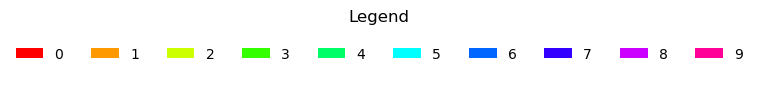

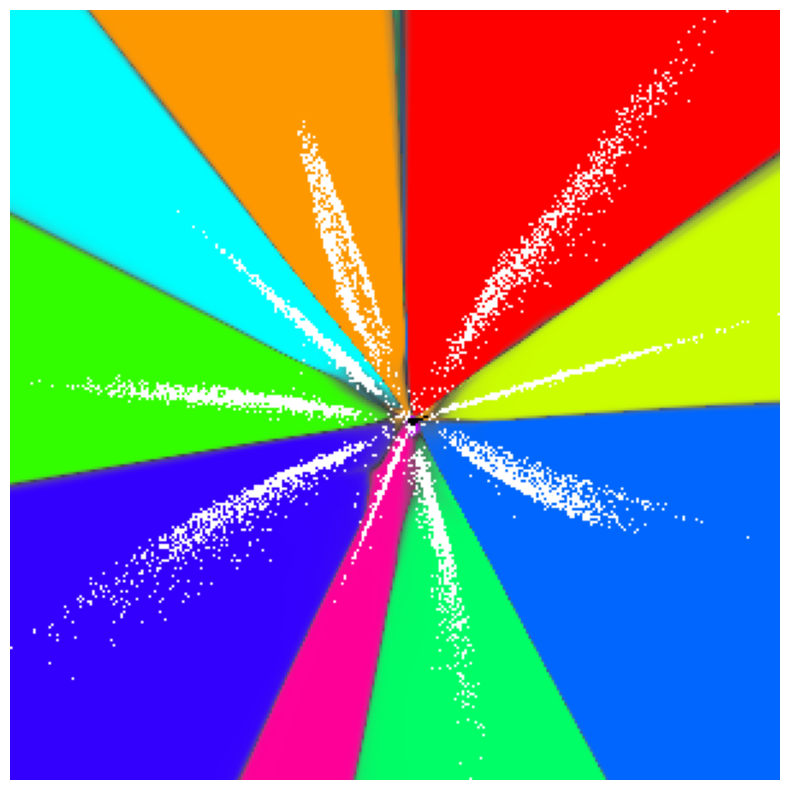

 69/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Processing 10200 points for 2D projection...
pts: [[-5.78625154 -6.5584507 ]
 [-5.78625154 -6.51662316]
 [-5.78625154 -6.47479563]
 ...
 [ 5.04568672  5.86432724]
 [ 5.04568672  5.90615478]
 [ 5.04568672  5.94798231]]
x, y intervals: [-5.78625154 -5.75002433 -5.71379711 -5.67756989 -5.64134267 -5.60511545
 -5.56888824 -5.53266102 -5.4964338  -5.46020658 -5.42397936 -5.38775214
 -5.35152493 -5.31529771 -5.27907049 -5.24284327 -5.20661605 -5.17038883
 -5.13416162 -5.0979344  -5.06170718 -5.02547996 -4.98925274 -4.95302552
 -4.91679831 -4.88057109 -4.84434387 -4.80811665 -4.77188943 -4.73566221
 -4.699435   -4.66320778 -4.62698056 -4.59075334 -4.55452612 -4.51829891
 -4.48207169 -4.44584447 -4.40961725 -4.37339003 -4.33716281 -4.3009356
 -4.26470838 -4.22848116 -4.19225394 -4.15602672 -4.1197995  -4.08357229
 -4.04734507 -4.01111785 -3.97489063 -3.93866341 -3.90243619 -3.86620898
 -3.82998176 -3.79375454 -3.75752732 -3.7213001  -3.68507288 -3.64884567

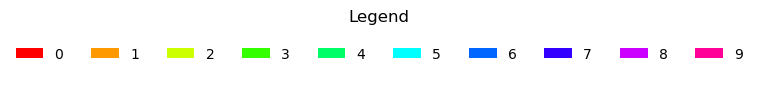

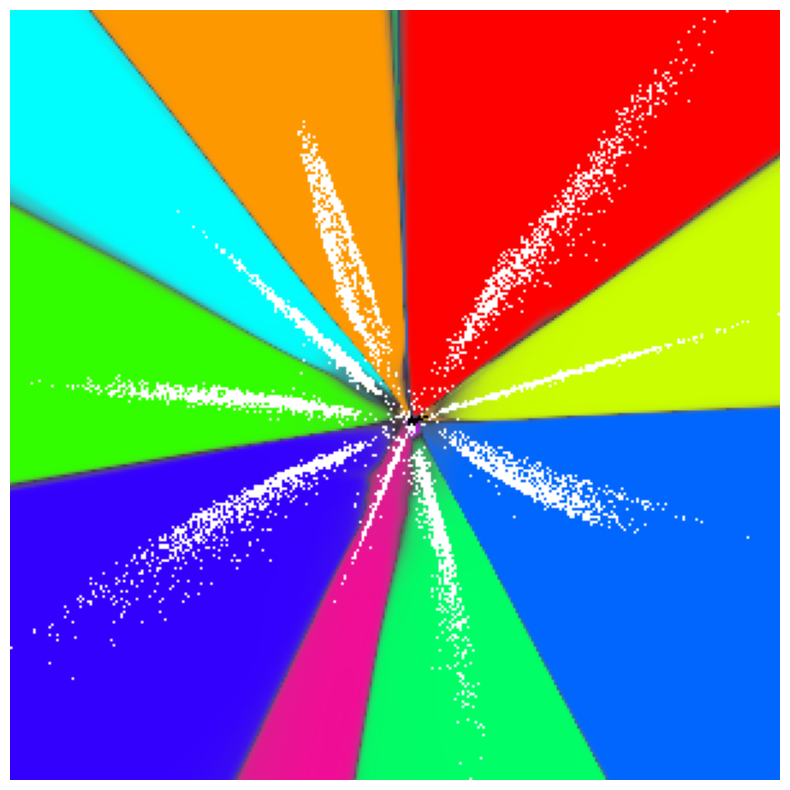

In [5]:
# Loop through all trained models to produce adversarial examples
MODELS = ["Constant", "Cyclic", "Exponential", "Linear", "LinearUniformMix", "Random"]
#MODELS = ["Cyclic", "Exponential", "Linear", "LinearUniformMix"]
#MODELS = ["Cyclic"]
MODEL_REPO_ID = "JulienStal/MNIST-MediumConvs-AdversarialSchedulers"
EPSILON = 0.3
K = 10
BATCH_SIZE = 10000
EPOCHS = 300
PATIENCE = 100

ssnps = []
im_grids = []
prob_grids = []
dbms = []
models = []
pts_arr = []

for model in MODELS:
    # Import the model weights from HuggingFace
    model_name = f"{MODEL_SETTING}_conv_{model}"
    model_file_name = f"model_{model}.pth"    
    local_pth_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename=model_file_name, force_download=False)    
    MNIST_model.load_state_dict(torch.load(local_pth_path, map_location=device_torch))

    for idx, (image, label) in enumerate(zip(adversarial_images, adversarial_labels)):
        if image.dim() == 2: image = image.unsqueeze(0).unsqueeze(0)
        elif image.dim() == 3: image = image.unsqueeze(0)
        label = torch.tensor([label])  # Make label a batch

        adv_image, perturbation = Attacks.pgd_attack(image, label, MNIST_model, nn.CrossEntropyLoss(), EPSILON, K, device_torch)
        adversarial_images[idx] = adv_image.squeeze()

    # Generate visualization
    ssnp, im_grid, prob_grid, dbm, pts = visualize_decision_boundaries(
        original_dataset = MNIST_data,
        dataset_name = "MNIST",
        classifier_model = MNIST_model,
        classifier_model_name = model_name,
        ssnp_path_and_name = local_path,
        batch_size = BATCH_SIZE,
        adversarial_images=adversarial_images,
        ssnp_training_epochs = EPOCHS,
        ssnp_training_patience = PATIENCE,
        verbose = True,
    )

    ssnps.append(ssnp)
    im_grids.append(im_grid)
    prob_grids.append(prob_grid)
    dbms.append(dbm)
    models.append(MNIST_model)
    pts_arr.append(pts)

In [6]:
# Save the SSNP .keras model to HuggingFace
SAVE_SSNP_HF = True

if SAVE_SSNP_HF:
    api = HfApi()
    api.upload_file(
        path_or_fileobj=local_path,
        path_in_repo="ssnp_MNIST.keras",
        repo_id=SSNP_REPO_ID,
        repo_type="model"
    )

No files have been modified since last commit. Skipping to prevent empty commit.


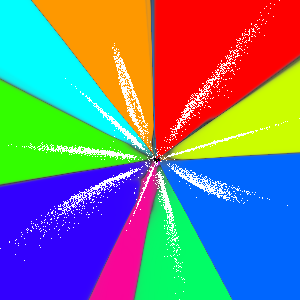

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Label of synthetic image at pixel (156, 156): 6.0 (confidence 0.44)


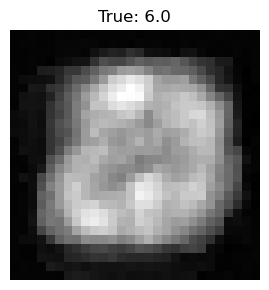

Output probabilities: 0: 0.20 | 1: 0.00 | 2: 0.29 | 3: 0.14 | 4: 0.01 | 5: 0.20 | 6: 0.04 | 7: 0.01 | 8: 0.08 | 9: 0.03


In [17]:
# Print the synthetic image for a given pixel
PIXEL_X, PIXEL_Y = (156, 156) # vertical and horizontal
index = PIXEL_X*300 + PIXEL_Y

ssnp = ssnps[0]
img_grid = im_grids[0]
prob_grid = prob_grids[0]
dbm = dbms[0]
model = models[0]
pts = pts_arr[0]

# Set pixel to red in the dbm and display
dbm.putpixel((PIXEL_Y, PIXEL_X), (255, 0, 0))  # Set pixel to red
display(dbm)

# Points values of the pixel
pt = pts[36211]

# Get the synthetic image for the given pixel and print it
synthetic_img = torch.tensor(ssnp.inverse_transform(torch.tensor(pt).unsqueeze(0))).view(1, 1, 28, 28)
label_tensor = torch.tensor(img_grid[PIXEL_X][PIXEL_Y]).view(1,1)

# Print the label of the synthetic image
print(f"Label of synthetic image at pixel ({PIXEL_X}, {PIXEL_Y}): {label_tensor.item()} (confidence {prob_grid[PIXEL_X][PIXEL_Y]:.2f})")

Tools.plot_predictions(model, synthetic_img, label_tensor, device_torch, 1)

In [16]:
import numpy as np
min_pixel = np.argmin(prob_grid.flatten())
print(min_pixel)

36211
